# Ансамбли решающих деревьев: оценка значимости признаков

# Теоретическая часть


## Оценка значимости признаков ансамблей решающих деревьев

На практике важность признаков можно получить следующими способами: 
* **С помощью встроенных функций в ту или иную библиотеку**. В данном семинаре мы будем рассматривать ансамбли решающих деревьев из библиотек `xgboost` и `sklearn`, в которые уже встроена возможность получения важности признаков после обучения модели
* **С помощью SHAP-значений**. Положительные значения означают «положительное» влияние на прогноз, т. е. что данный признак приводит модель к предсказанию класса $1$; отрицательные значения — «отрицательное» влияние на прогноз — приводит модель к предсказанию класса $0$. Про SHAP-значения будет подробнее рассказано далее в курсе. Для их получения будем использовать библиотеку `shap`
* **Forward, backward selection, forward-backward отбор признаков**:   
    - **прямой отбор (Forward selection)**: начинаем с пустого набора признаков, а затем итеративно добавляем признаки, обеспечивающие наилучший прирост качества моделей
    - **обратный отбор (Backward selection)**: начинаем с набора, состоящего из всех признаков, далее на каждой итерации убираем «худший» признак
    - **Forward-backward selection**: основная идея заключается в добавлении или удалении признаков и вычислении того, как это удаление влияет на значение функции потерь или некоторых других критериев. Будем использовать реализацию данного метода в [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html). Поскольку он возвращает лишь признаки в порядке их важности, то будем сравнивать отсортированные в порядке возрастания/убывания важности списки признаков с данным методом (а первые два метода оценки значимости признаков будем визуализировать)

## Оценка значимости признаков в линейных моделях 

# Практическая часть

Будем использовать датасет [отсюда](https://www.kaggle.com/datasets/whenamancodes/predict-diabities). Данные были предоставлены Национальным институтом диабета, болезней органов пищеварения и почек. Необходимо построить модель, предсказывающую, есть ли у пациента диабет, на основе определенных диагностических измерений.

## Скачивание данных

In [ ]:
# Уберем предупреждения, чтобы они не загромождали вывод

import warning|s 
warnings.filterwarnings('ignore')

In [ ]:
# Установим размеры шрифтов для графиков
import matplotlib.pyplot as plt

plt.rc('font', size=16)          # размеры текста по умолчанию
plt.rc('axes', titlesize=20)     # размер шрифта заголовка осей
plt.rc('axes', labelsize=18)     # размер шрифта названия осей
plt.rc('xtick', labelsize=18)    # размер шрифта меток по оси x
plt.rc('ytick', labelsize=18)    # размер шрифта меток по оси y
plt.rc('legend', fontsize=16)    # размер шрифта легенды
plt.rc('figure', titlesize=20)   # размер шрифта заголовка всего графика

## Разведочный анализ и предобработка данных

In [ ]:
import pandas as pd

df = pd.read_csv("diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
target = df["Outcome"]

df = df.drop("Outcome", axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


Кажется, что все колонки численные. Проверим это:

In [ ]:
numerical_cols = df.select_dtypes(exclude=["object"]).columns.tolist()
len(numerical_cols) == df.shape[1]

True

In [ ]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Пропусков в данных нет, все признаки численные, и мы собираемся использовать ансамбли деревьев, поэтому нормализацию признаков проводить не будем.

## Деление выборки на обучающую и тестовую

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    target,
    test_size=0.33,
    random_state=42,
    stratify=target, # поделим выборку таким образом, чтобы и в обучающей, и в тестовой выборке было такое же соотношение классов, как и в исходных данных
)
X_train.shape, X_test.shape

((514, 8), (254, 8))

## Выбор метрик качества 

In [ ]:
# Посмотрим на баланс классов 

val_count_init = pd.Series(target).value_counts().to_dict()
val_count_train = y_train.value_counts().to_dict()
val_count_test = y_test.value_counts().to_dict()

get_relation = lambda x: round(x[1] / x[0], 2)

print(
    """
    Соотношение классов в исходной выборке:  {}\t(класс 1 / класс 0 = {})
    Соотношение классов в обучающей выборке: {}\t(класс 1 / класс 0 = {})
    Соотношение классов в тестовой выборке:  {}\t(класс 1 / класс 0 = {})
    """.format(
        val_count_init, get_relation(val_count_init),
        val_count_train, get_relation(val_count_train),
        val_count_test, get_relation(val_count_test),
    )
)


    Соотношение классов в исходной выборке:  {0: 500, 1: 268}	(класс 1 / класс 0 = 0.54)
    Соотношение классов в обучающей выборке: {0: 335, 1: 179}	(класс 1 / класс 0 = 0.53)
    Соотношение классов в тестовой выборке:  {0: 165, 1: 89}	(класс 1 / класс 0 = 0.54)
    


Поскольку выборки у нас несбалансированные, будем использовать F1-меру и PR AUC.

In [ ]:
from sklearn.metrics import (
    f1_score, 
    average_precision_score,
)

Для вычисления и выведения F1-меры и PR AUC будем использовать функцию из ячейки ниже:

In [ ]:
import numpy as np

def get_all_metrics(
    true_labels, 
    predictions, 
    probabilities, 
    print_metrics=False,
):
    """Подсчёт и вывод всех метрик.

    :param true_labels: истинные метки классов
    :param predictions: предсказания (метки классов)
    :param probabilities: предсказания (вероятности принадлежности каждого объекта к каждому классу)
    :param print_metrics: если True, то печатает получившиеся метрики
    :return: словарь, ключи которого -- названия метрик, значения -- получившиеся метрики   
    """
    f1 = f1_score(true_labels, predictions)
    pr_auc =  average_precision_score(true_labels, probabilities)
    
    if print_metrics:
        print(
            "F1-мера = {}\nPR AUC = {}".format(
                round(f1, 3), round(pr_auc, 3)
            )
        )
    return {
        "F1-score": f1, 
        "PR AUC": pr_auc,
    }

## Выбор, обучение и тестирование моделей

Будем сравнивать все типы ансамблей моделей, в основе которых лежит решающее дерево. 

In [ ]:
from xgboost import XGBClassifier                   # градиентный бустинг 
from sklearn.ensemble import (
    AdaBoostClassifier,                             # адаптивный бустинг
    RandomForestClassifier,                         # бэггинг
    StackingClassifier,                             # стекинг
    VotingClassifier,                               # вотинг
)

from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression

Функция в ячейке ниже используется для обучения, тестирования модели и вычисления метрик качества. 

In [ ]:
import matplotlib.pyplot as plt

def model_train_test(X_train, y_train, X_test, y_test, model):
    """Обучение и тестирование модели на обучающей и тестовой выборке соответственно.

    :param X_train: объекты обучающей выборки
    :param y_train: значения целевой переменной обучающей выборки
    :param X_test: объекты тестовой выборки
    :param y_test: значения целевой переменной тестовой выборки
    :param model: модель, которая обучается и тестируется
    :return: предсказания -- классы и вероятности принадлежности к каждому классу, все метрики  
    """
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)

    print(str(model), end="\n\n")

    all_metrics = get_all_metrics(
        y_test, 
        pred, 
        proba[:, 1], 
        print_metrics=True,
    )
    return model, pred, proba, all_metrics

Будем сравнивать алгоритмы с гиперпараметрами по умолчанию (подбор гиперпараметров делать не будем). 

In [ ]:
model_logreg, pred_logreg, proba_logreg, all_metrics_logreg = model_train_test(
    X_train, y_train,
    X_test, y_test,
    LogisticRegression(),
)

LogisticRegression()

F1-мера = 0.596
PR AUC = 0.728


In [ ]:
model_xgb, pred_xgb, proba_xgb, all_metrics_xgb = model_train_test(
    X_train, y_train,
    X_test, y_test,
    XGBClassifier(),
)

XGBClassifier()

F1-мера = 0.617
PR AUC = 0.697


In [ ]:
model_adab, pred_adab, proba_adab, all_metrics_adab = model_train_test(
    X_train, y_train,
    X_test, y_test,
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier()
    ),
)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

F1-мера = 0.473
PR AUC = 0.418


In [ ]:
model_rf, pred_rf, proba_rf, all_metrics_rf = model_train_test(
    X_train, y_train,
    X_test, y_test,
    RandomForestClassifier(),
)

RandomForestClassifier()

F1-мера = 0.625
PR AUC = 0.698


In [ ]:
model_trees_stacking, pred_trees_stacking, proba_trees_stacking, all_metrics_trees_stacking = model_train_test(
    X_train, y_train,
    X_test, y_test,
    StackingClassifier(
        estimators=[
            ("decision_tree_{}".format(i+1), DecisionTreeClassifier()) for i in range(10)
        ],
        final_estimator=DecisionTreeClassifier()
    ),
)

StackingClassifier(estimators=[('decision_tree_1', DecisionTreeClassifier()),
                               ('decision_tree_2', DecisionTreeClassifier()),
                               ('decision_tree_3', DecisionTreeClassifier()),
                               ('decision_tree_4', DecisionTreeClassifier()),
                               ('decision_tree_5', DecisionTreeClassifier()),
                               ('decision_tree_6', DecisionTreeClassifier()),
                               ('decision_tree_7', DecisionTreeClassifier()),
                               ('decision_tree_8', DecisionTreeClassifier()),
                               ('decision_tree_9', DecisionTreeClassifier()),
                               ('decision_tree_10', DecisionTreeClassifier())],
                   final_estimator=DecisionTreeClassifier())

F1-мера = 0.527
PR AUC = 0.445


In [ ]:
model_trees_voting, pred_trees_voting, proba_trees_voting, all_metrics_trees_voting = model_train_test(
    X_train, y_train,
    X_test, y_test,
    VotingClassifier(
        estimators=[
            ("decision_tree_{}".format(i+1), DecisionTreeClassifier()) for i in range(10)
        ],
        voting="soft"
    ),
)

VotingClassifier(estimators=[('decision_tree_1', DecisionTreeClassifier()),
                             ('decision_tree_2', DecisionTreeClassifier()),
                             ('decision_tree_3', DecisionTreeClassifier()),
                             ('decision_tree_4', DecisionTreeClassifier()),
                             ('decision_tree_5', DecisionTreeClassifier()),
                             ('decision_tree_6', DecisionTreeClassifier()),
                             ('decision_tree_7', DecisionTreeClassifier()),
                             ('decision_tree_8', DecisionTreeClassifier()),
                             ('decision_tree_9', DecisionTreeClassifier()),
                             ('decision_tree_10', DecisionTreeClassifier())],
                 voting='soft')

F1-мера = 0.529
PR AUC = 0.495


Для удобства анализа получившихся результатов сагрегируем их. 

In [ ]:
metrics_df = pd.DataFrame(
    [all_metrics_logreg, all_metrics_adab, all_metrics_xgb, all_metrics_rf, all_metrics_trees_stacking, all_metrics_trees_voting], 
    index=["Logistic Regression", "AdaBoost", "XGBoost", "RandomForest", "Stacking", "Voting"]
)
metrics_df.sort_values(by=["F1-score", "PR AUC"], ascending=False)

,F1-score,PR AUC
RandomForest,0.625000,0.697630
XGBoost,0.617284,0.697381
Logistic Regression,0.596273,0.727906
Voting,0.529412,0.495224
Stacking,0.526946,0.445035
AdaBoost,0.473373,0.417632


Таким образом, судя по F1-мере и PR AUC, наилучшими алгоритмами в данном случае являются случайный лес и логистическая регрессия. Однако метрики получились для всех моделей невысокие.

## Важность признаков

Изначально значения Шепли (SHAP-значения, SHAP-values) применялись в теории игр для оценивания вклада каждого из участников кооперативной игры (в которой игроки действуют совместно).  

Более подробное математическое описание приведено в лонгриде. С практической точки зрения значения Шепли (из библиотеки `shap`) могут применяться для признаков табличных данных (показывают, как значения каждого признака влияют на предсказания), при работе с текстами (например, могут применяться для исследования влияния слов при классификации текстов по эмоциональному окрасу) и изображениями (значения Шепли будут показывать, как повлиял на принятие решения моделью тот или иной пиксель изображения). 

Сначала рассмотрим важность признаков логистической регрессии. Для линейных моделей в качестве важности признаков можно использовать коэффициент при соответствующем признаке. 

In [ ]:
logreg_coefs = np.abs(model_logreg.coef_).squeeze()

In [ ]:
print(
    "Наиболее важный признак: {}\nНаименее важный признак: {}".format(
        X_train.columns[np.argmax(logreg_coefs)],
        X_train.columns[np.argmin(logreg_coefs)]
    )
)

наиболее важный признак: DiabetesPedigreeFunction
Наименее важный признак: Insulin


Визуализируем признаки в порядке их важности. 

In [ ]:
sorted_idx = np.argsort(logreg_coefs)
sorted_cols = X_train.columns[sorted_idx].tolist()
sorted_fi = logreg_coefs[sorted_idx]

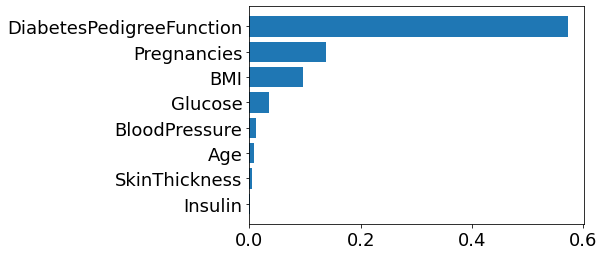

In [ ]:
plt.barh(sorted_cols, sorted_fi);

Перейдем к ансамблям:

In [ ]:
# Чтобы установить библиотеку shap, раскомментируйте строку ниже

# !pip install shap

In [ ]:
import shap

Для извлечения важности признаков будем использовать функцию из ячейки ниже:

In [ ]:
def get_model_name_fi(model, fi_type, X_train=None):
    """Получение важности признаков.

    :param model: обученная модель
    :param fi_type: тип определения важности признаков: 'builded' -- встроенный в класс используемой модели или 'shap' -- с помощью shap-значений
    :param X_train: обучающая выборка (необходима при fi_type='shap')
    :return: название модели и важности признаков
    """
    model_name = str(model)[:str(model).find("(")]

    if fi_type == "builded":
        if "xgbclassifier" in model_name.lower() or "randomforest" in model_name.lower():
            fi = model.feature_importances_
        else:
            # AdaBoostClassifier, StackingClassifier и VotingClassifier не имеют встроенной функции определения важности признаков,
            # но т.к. у нас в оснвое лежат деревья, то мы посчитаем средние важности по всем деревьям
            fi = np.concatenate(
                [
                    dt.feature_importances_.reshape((1, -1)) for dt in model.estimators_
                ]
            ).mean(axis=0)
    elif fi_type == "shap":
        explainer = shap.TreeExplainer(model)
        fi = explainer.shap_values(X_train)
    return model_name, fi

Также визуализируем важности признаков для разных моделей с помощью гистограмм: 

In [ ]:
def plot_several_models_feature_importances(models, features, fi_type, X_train=None):
    """Визуализирует важности признаков. 

    :param models: список обучненных моделей 
    :param features: названия признаков
    :param fi_type: тип определения важности признаков: 'builded' -- встроенный в класс используемой модели или 'shap' -- с помощью shap-значений
    :param X_train: обучающая выборка (необходима при fi_type='shap')
    """
    N = len(models)
    plt.figure(figsize=(10 * N, 8 * (N // 2 + 1)))

    for i, model in enumerate(models):
        model_name, fi = get_model_name_fi(model, fi_type, X_train=X_train)

        if fi_type == "builded":
            plt.subplot(2, N // 2 + 1, i + 1)
            sorted_idx = np.argsort(models[0].feature_importances_)[::-1]
            plt.barh(features[sorted_idx], fi[sorted_idx])
            plt.title(model_name);
        elif fi_type == "shap":
            shap.summary_plot(fi, X_train, plot_type="bar")
    
    if fi_type == "builded":
        plt.subplot(2, N // 2 + 1, i + 2)
        for i, model in enumerate(models):
            model_name, fi = get_model_name_fi(model, fi_type, X_train=X_train)
            plt.barh(features[sorted_idx], fi[sorted_idx], alpha=0.5, label=model_name)
        plt.legend()
        plt.title("All models");

    plt.show()

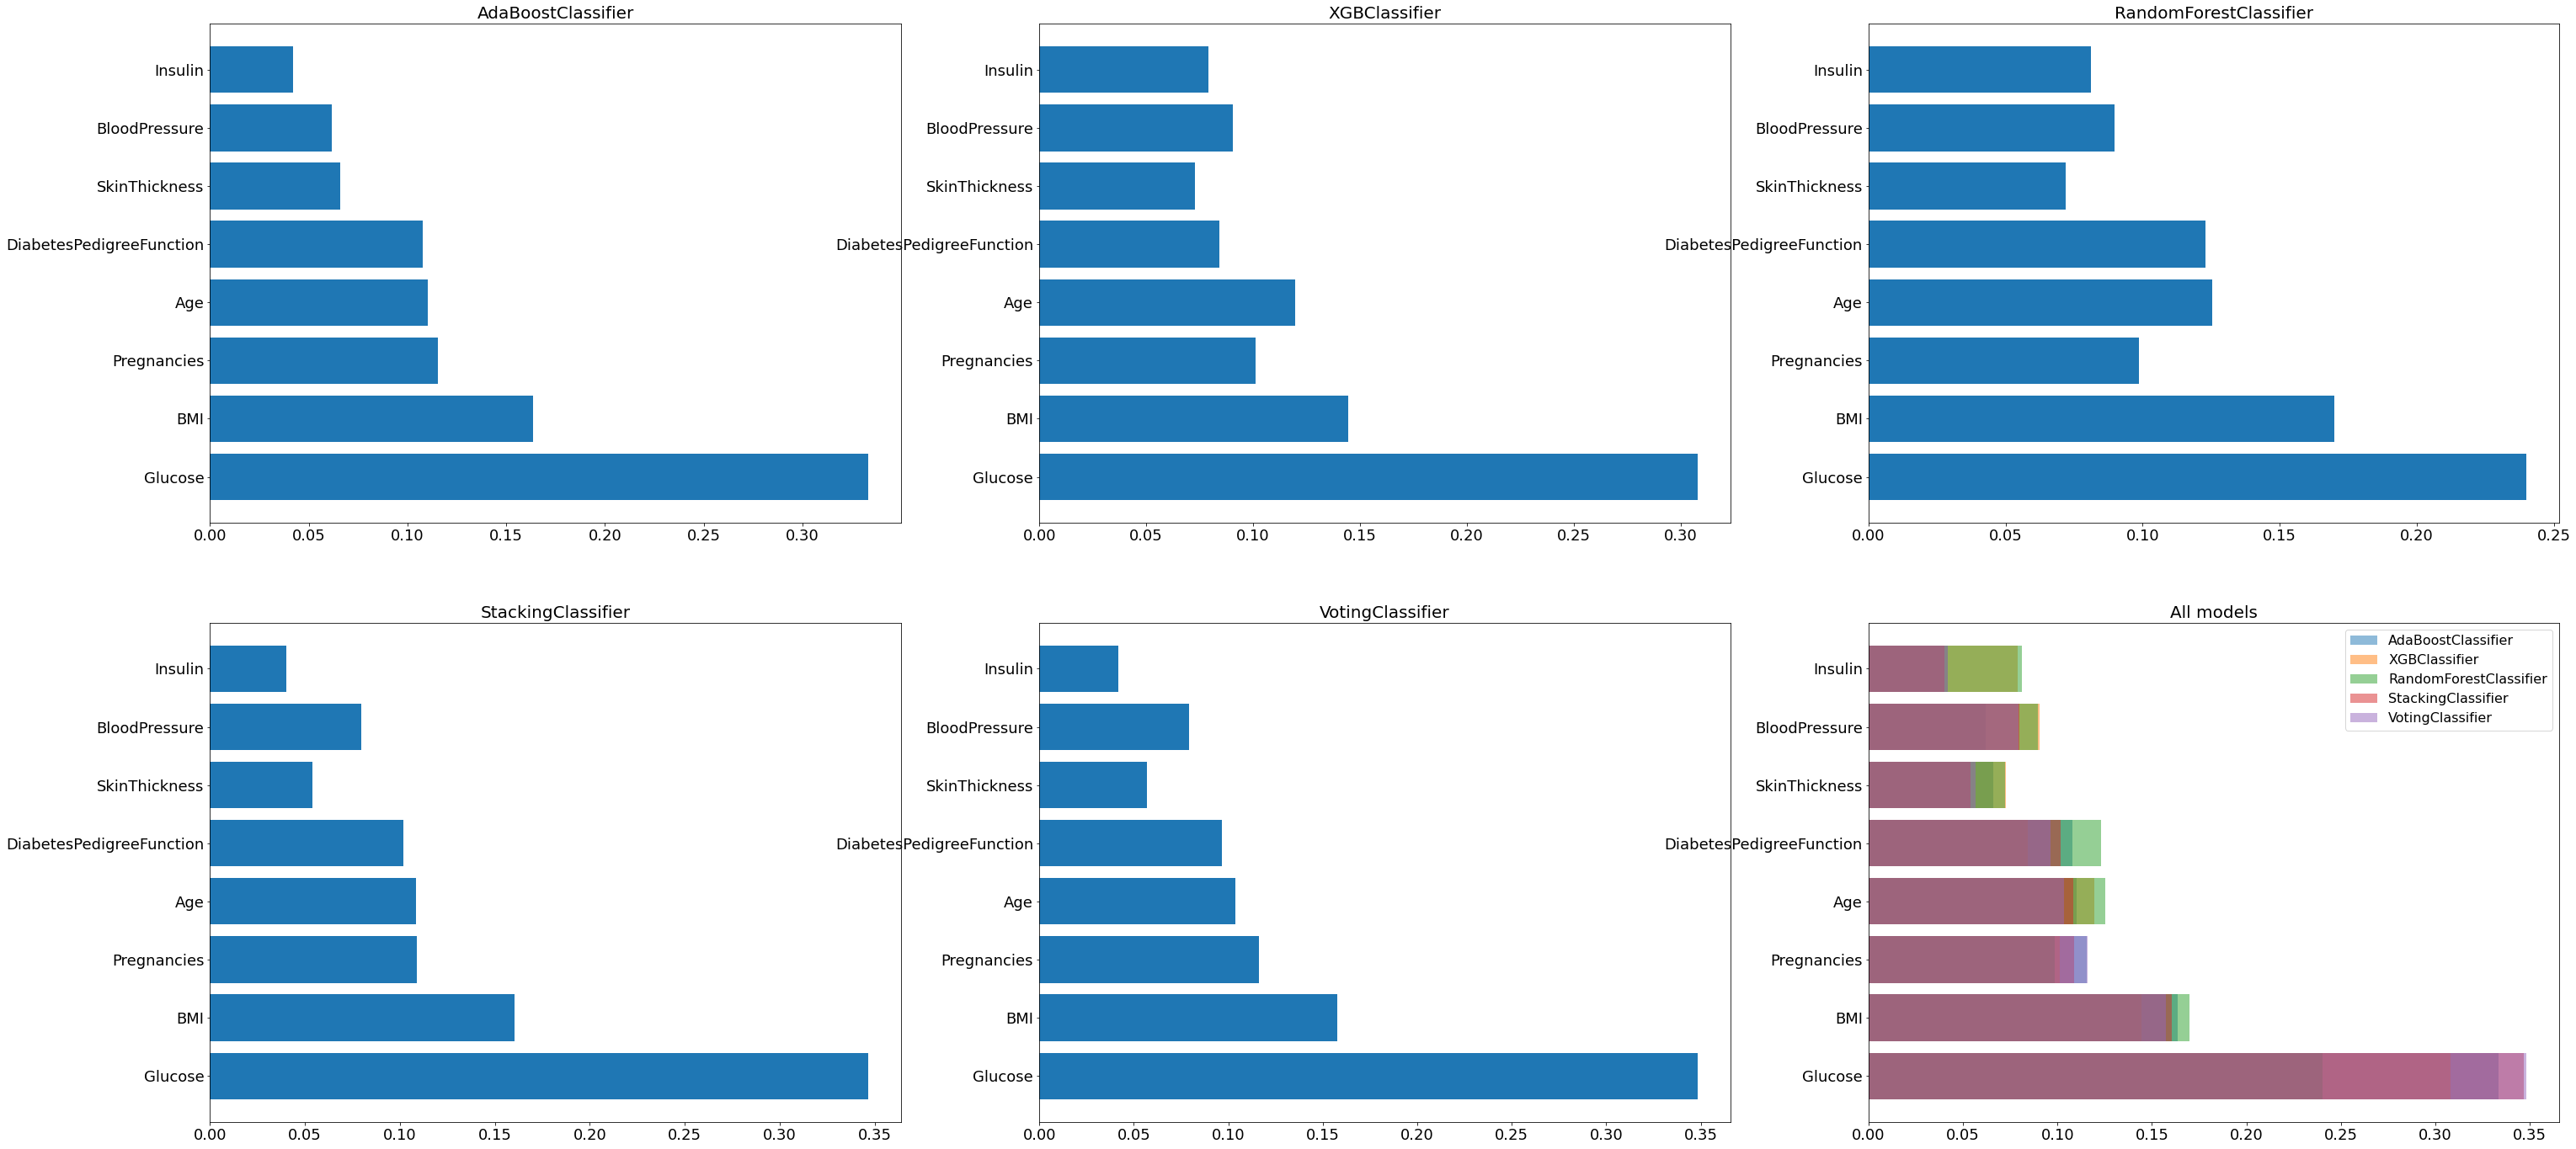

In [ ]:
plot_several_models_feature_importances(
    models=[
        model_adab,
        model_xgb,
        model_rf,
        model_trees_stacking,
        model_trees_voting,
    ], 
    features=X_train.columns,
    fi_type="builded",
)

Важности признаков для разных моделей получились разные, но следует заметить, что все модели определили наиболее важным признаком уровень глюкозы `Glucose`. 

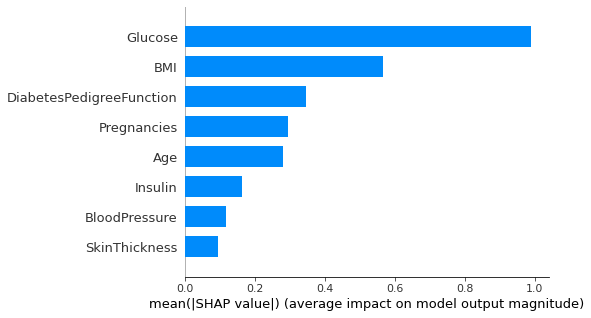

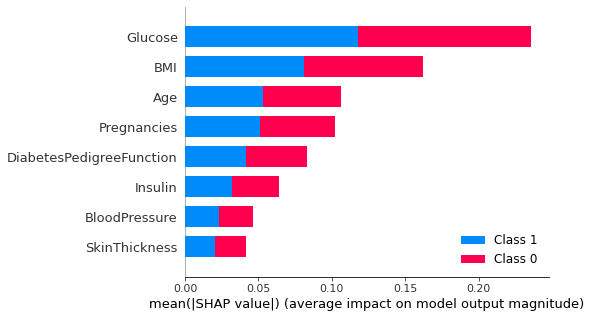

In [ ]:
plot_several_models_feature_importances(
    models=[
        model_xgb,
        model_rf, 
        # остальные рассматриваемые нами модели не поддерживаются shap.TreeExplainer, поэтому рассмотрим только эти две модели
    ], 
    features=X_train.columns,
    fi_type="shap",
    X_train=X_train,
)

Как видно из графиков выше, встроенная важность признаков отличается от важности, полученной с помощью `shap`-значений. 

Рассмотрим подробнее `XGBoost`:
1. Возьмем топ-5 лучших признаков по мнению `xgboost` и обучим на них модель
2. Возьмем топ-5 худших признаков и обучим на них модель

Ожидается, что качество в первом варианте будет сильно выше, чем качество во втором варианте. Аналогичные эксперименты проведем с важностью, полученной с помощью `shap`-значений и `forward-backward-отбора`.

In [ ]:
def train_test_n_most_worst_important(n, sorted_idx, columns, model, X_train, y_train, X_test, y_test):
    """Обучение и тестирование модели на n наиболее и наименее важных признаках.

    :param n: количество используемых признаков
    :param sorted_idx: индексы отсортированных по возрастанию важностей признаков 
    :param columns: колонки (признаки) исходных данных в исходном порядке 
    :param model: модель
    :param X_train: обучающая выборка (без целевой переменной)
    :param y_train: целевая переменная обучающей выборки
    :param X_test: тестовая выборка (без целевой переменной)
    :param y_test: целевая переменная тестовой выборки
    :return: кортеж из следующих кортежей: 
             1: 
                - n наиболее важных признаков
                - модель, обученная на n наиболее важных признаках
                - предсказания модели (метки классов)
                - предсказания модели (верочтнояти принадлежности к классам)
                - метрики: F1-мера и PR AUC
            2: аналогичный набор, но для n наименее важных признаков
    """
    # наиболее важные признаки
    top_n_features = columns[sorted_idx[:-n-1:-1]].tolist()
    print(
        "{} наиболее важных признаков:\n{}".format(
            n, top_n_features
        )
    )
    model_top_n, pred_top_n, proba_top_n, all_metrics_top_n = model_train_test(
        X_train[top_n_features], y_train,
        X_test[top_n_features], y_test,
        model,
    )
    print("-"*100)
    # наименее важные признаки
    bottom_n_features = columns[sorted_idx[:n]].tolist()
    print(
        "{} наименее важных признаков:\n{}".format(
            n, bottom_n_features
        )
    )
    model_bottom_n, pred_bottom_n, proba_bottom_n, all_metrics_bottom_n = model_train_test(
        X_train[bottom_n_features], y_train,
        X_test[bottom_n_features], y_test,
        model,
    )
    return (
        (
           top_n_features,
           model_top_n,
           pred_top_n,
           proba_top_n,
           all_metrics_top_n
       ), (
            bottom_n_features,
            model_bottom_n,
            pred_bottom_n,
            proba_bottom_n,
            all_metrics_bottom_n
        )
    )

In [ ]:
# Создадим словарь из аргументов функции, которые не будут меняться при вызовах 
# функции `train_test_n_most_worst_important`

CONFIG = {
    "n": 5,
    "columns": X_train.columns, 
    "model": XGBClassifier(), 
    "X_train": X_train, 
    "y_train": y_train, 
    "X_test": X_test, 
    "y_test": y_test,
}

In [ ]:
_, fi_xgb = get_model_name_fi(model_xgb, fi_type="builded")
sorted_idx_xgb = np.argsort(fi_xgb)

best_xgb, worst_xgb = train_test_n_most_worst_important(
    sorted_idx=sorted_idx_xgb, 
    **CONFIG
)

5 наиболее важных признаков:
['Glucose', 'BMI', 'Age', 'Pregnancies', 'BloodPressure']
XGBClassifier()

F1-мера = 0.643
PR AUC = 0.68
----------------------------------------------------------------------------------------------------
5 наименее важных признаков:
['SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'BloodPressure', 'Pregnancies']
XGBClassifier()

F1-мера = 0.368
PR AUC = 0.473


In [ ]:
_, fi_xgb_shap = get_model_name_fi(model_xgb, fi_type="shap", X_train=X_train)

# В `fi_xgb_shap` находится значение важности каждого значения выборки, т.е. 
# размер `fi_xgb_shap`: <кол-во элементов в выборке> x <кол-во признаков>. 
# Причем если часть значений отрицательные. Поэтому нам необходимо для каждого признака 
# посчитать среднее по модулю значение -- это число и будет важностью того или иного признака. 

fi_xgb_shap = np.abs(fi_xgb_shap).mean(axis=0)

sorted_idx_xgb_shap = np.argsort(fi_xgb_shap)

best_xgb_shap, worst_xgb_shap = train_test_n_most_worst_important(
    sorted_idx=sorted_idx_xgb_shap, 
    **CONFIG
)

5 наиболее важных признаков:
['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age']
XGBClassifier()

F1-мера = 0.605
PR AUC = 0.692
----------------------------------------------------------------------------------------------------
5 наименее важных признаков:
['SkinThickness', 'BloodPressure', 'Insulin', 'Age', 'Pregnancies']
XGBClassifier()

F1-мера = 0.362
PR AUC = 0.49


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

fbs = SequentialFeatureSelector(XGBClassifier(), n_features_to_select=5)
fbs.fit(X_train, y_train)
top_5_features_xgb_fbs = X_train.columns[fbs.support_]

print("5 наиболее важных признаков:\n", top_5_features_xgb_fbs)

best_xgb_fbs = model_train_test(
    X_train[top_5_features_xgb_fbs], y_train,
    X_test[top_5_features_xgb_fbs], y_test,
    XGBClassifier(),
)

5 наиболее важных признаков:
 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI'], dtype='object')
XGBClassifier()

F1-мера = 0.593
PR AUC = 0.668


In [ ]:
# Поскольку SequentialFeatureSelector не выдает численную важность, то выберем признаки, 
# не попавшие в список наиболее важных, которые будем использовать как наименее важные

bottom_5_features_xgb_fbs = X_train.columns[~fbs.support_] 
# таких признаков будет всего 3, поскольку 5 уже отобраны как лучшие, а в исходной выборке всего 8 признаков

print("3 наименее важных признака:\n", bottom_5_features_xgb_fbs)

worst_xgb_fbs = model_train_test(
    X_train[bottom_5_features_xgb_fbs], y_train,
    X_test[bottom_5_features_xgb_fbs], y_test,
    XGBClassifier(),
)

3 наименее важных признака:
 Index(['Insulin', 'DiabetesPedigreeFunction', 'Age'], dtype='object')
XGBClassifier()

F1-мера = 0.493
PR AUC = 0.591


In [ ]:
metrics_df = pd.DataFrame(
    [
        best_xgb[-1], worst_xgb[-1],
        best_xgb_shap[-1], worst_xgb_shap[-1],
        best_xgb_fbs[-1], worst_xgb_fbs[-1]
    ], 
    index=[
        "XGBoost top 5 feats", "XGBoost bottom 5 feats", 
        "SHAP top 5 feats", "SHAP bottom 5 feats", 
        "FBS top 5 feats", "FBS bottom 5 feats"
    ]
)
metrics_df 

,F1-score,PR AUC
XGBoost top 5 feats,0.642857,0.679527
XGBoost bottom 5 feats,0.368421,0.473027
SHAP top 5 feats,0.604938,0.692427
SHAP bottom 5 feats,0.362416,0.490260
FBS top 5 feats,0.592593,0.668465
FBS bottom 5 feats,0.493333,0.590893


Как и ожидалось, метрики при использовании 5 «худших» признаков ниже, чем при использовании 5 «лучших» признаков. Попробуем визуализировать «лучшие» и «худшие» признаки для разных алгоритмов и сравнить, насколько пересекаются эти множества.

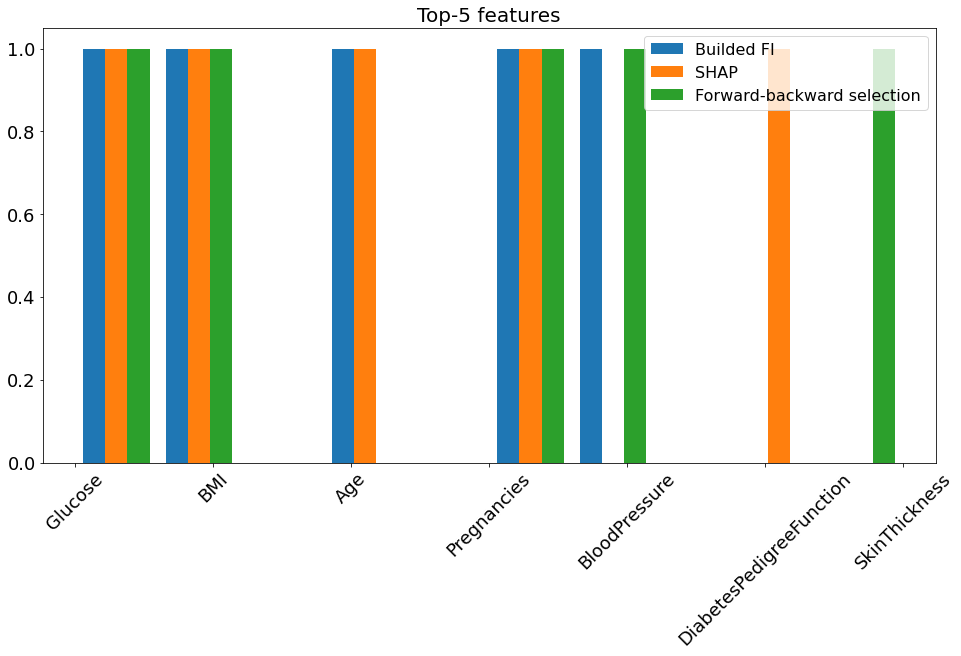

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("Top-5 features")
plt.hist(
    [best_xgb[0], best_xgb_shap[0], top_5_features_xgb_fbs], 
    label=["Builded FI", "SHAP", "Forward-backward selection"]
)
plt.xticks(rotation=45);
plt.legend();

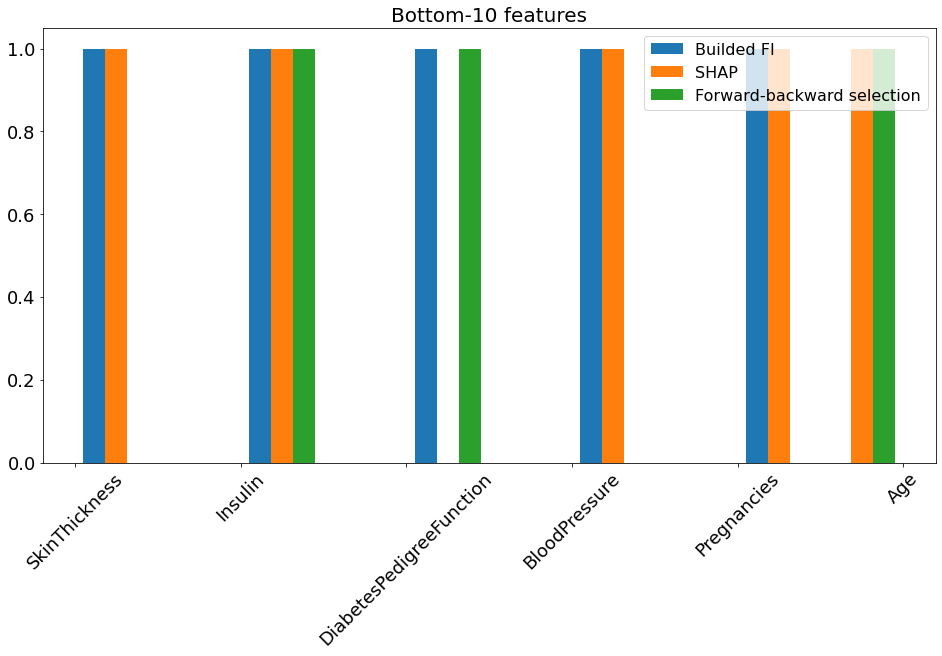

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("Bottom-10 features")
plt.hist(
    [worst_xgb[0], worst_xgb_shap[0], bottom_5_features_xgb_fbs],
    label=["Builded FI", "SHAP", "Forward-backward selection"]
)
plt.xticks(rotation=45);
plt.legend();

Как видно из графиков выше, пересечения есть, и их достаточно много.

In [ ]:
metrics_df.sort_values(by=["F1-score", "PR AUC"], ascending=False)

,F1-score,PR AUC
XGBoost top 5 feats,0.642857,0.679527
SHAP top 5 feats,0.604938,0.692427
FBS top 5 feats,0.592593,0.668465
FBS bottom 5 feats,0.493333,0.590893
XGBoost bottom 5 feats,0.368421,0.473027
SHAP bottom 5 feats,0.362416,0.490260


Из таблицы выше следует, что в нашем случае наилучшие комбинации признаков, которые дают наиболее высокие метрики, подобрали **XGBoost**  со встроенной оценкой важности признаков (судя по F1-мере) и **SHAP** (судя по PR AUC), **отбор forward-backward** показал чуть менее хороший результат. Однако модели для всех вариантов выбора признаков при использовании признаков top-5 или bottom-5  показали не сильно отличающиеся результаты. 

## Рассмотрим подробнее некоторые виды графиков из библиотеки `shap`

#### `shap.summary_plot`

Помимо прочего, в библиотеке `shap` есть много хороших визуализаций, которые помогают сделать вывод о причинах полученных предсказаний моделей и тем самым улучшить интерпретируемость моделей. Приведем примеры некоторых визуализаций:

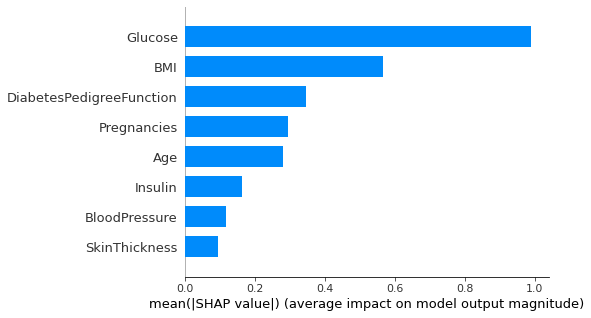

In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar") # ранее использованные гистограммы

Рассмотрим, как какие значения каждого признака влияют на предсказание модели (график в ячейке ниже). Каждая точка представляет собой одно SHAP-значение для предсказания и конкретного признака. Красный цвет точки соответствует высокой ценности объекта, синий — низкой. На основе распределения красных и синих точек мы можем получить представление о влиянии значений каждого конкретного признака.


В наших моделях чем ниже показатели глюкозы, тем ниже вероятность диабета, и чем выше показатель глюкозы, тем выше вероятность, что у пациента диабет. 

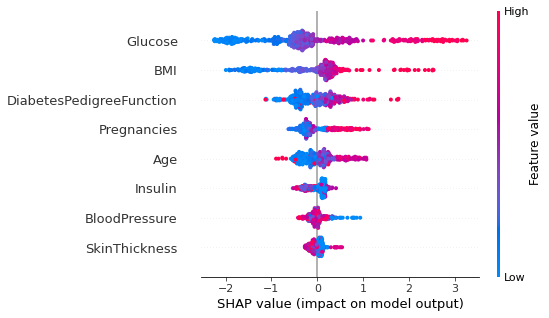

In [ ]:
shap.summary_plot(shap_values, X_train)

Из графика выше также следует, что `Glucose` — наиболее важный признак.

#### `shap.dependence_plot`

Также можно визуализировать, как выбранные признаки влияют на значения Шепли. Например, можно посмотреть, как уровень глюкозы `Glucose` влияет на наличие диабета. Для того чтобы задать признак, взаимодействие с которым мы хотим проанализировать для уже выбранного нами признака `Glucose`, нужно передать другой признак в качестве параметра `interaction_index` (если этот параметр не будет задан, то другой признак будет выбран автоматически). 

График из ячейки ниже свидетельствует о том, что уровень глюкозы имеет меньшее влияние на решение о диабете при молодом возрасте (< 30 лет).

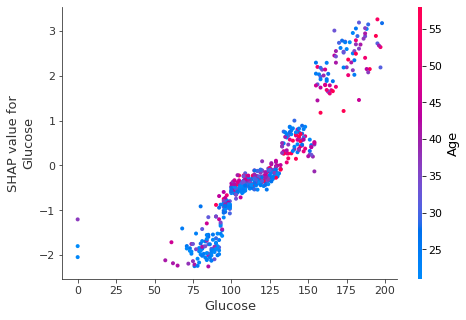

In [ ]:
shap.dependence_plot("Glucose", shap_values, X_train, interaction_index="Age")

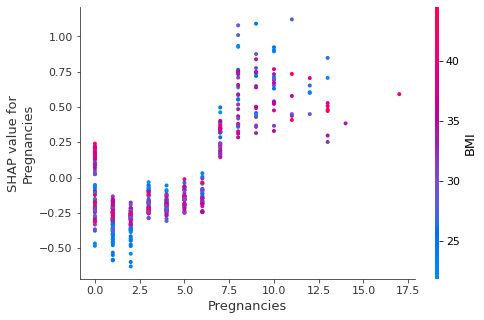

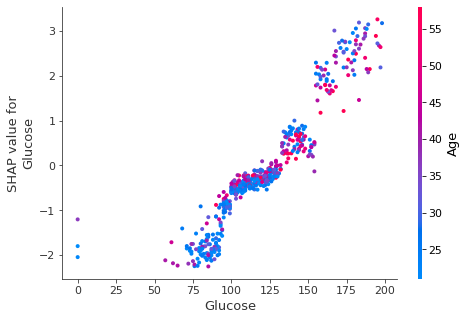

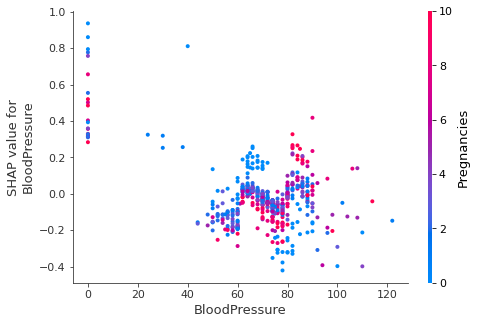

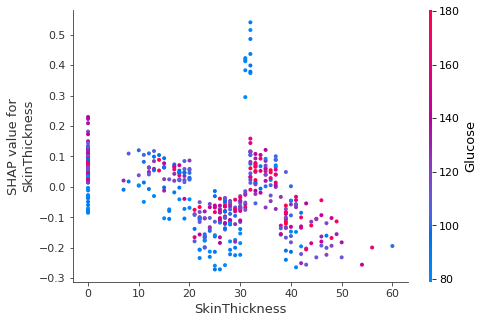

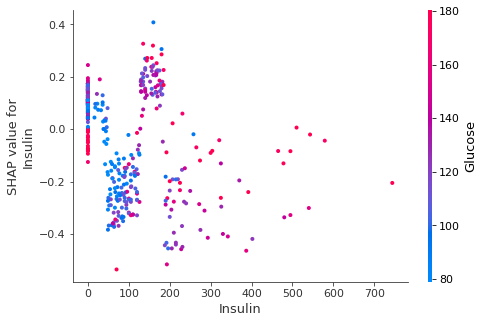

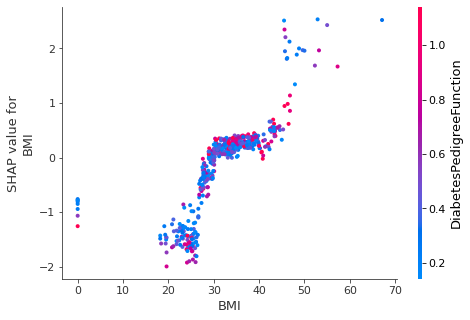

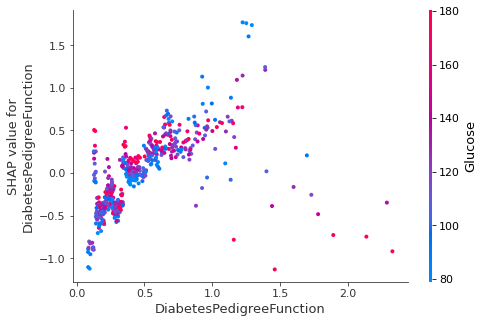

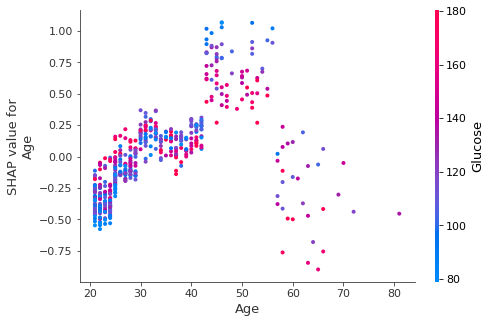

In [ ]:
# Графики для всех признаков можно построить следующим образом:

for feature in X_train.columns:
    shap.dependence_plot(feature, shap_values, X_train, display_features=X_train) 

#### `shap.force_plot`

Данный тип графиков позволяет посмотреть на конкретные наблюдения: как разные признаки влияют на предсказание модели. 

In [ ]:
# Для каждого наблюдения во всем наборе данных

shap.initjs() # для отображения интерактивного графика
shap.force_plot(explainer.expected_value, shap_values, features=X_train) 

In [ ]:
# Для конкретного наблюдения из данных 
# (в этой ячейке рассматривается первое наблюдение)

shap.initjs() # для отображения интерактивного графика
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0])

На графике выше `base_value` помечено среднее значение, полученное при обучении, а жирным выделено полученное значение. 

In [ ]:
shap.initjs() # для отображения интерактивного графика
shap.force_plot(explainer.expected_value, shap_values[1, :], X_train.iloc[1])

Конечно, ни один из рассматриваемых методов оценки важности признаков не идеален, однако, как показал эксперимент, все эти методы помогают выбрать такие признаки, при использовании которых модель будет хорошо обучаться. 